In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from google.colab import files
import cv2
import os
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from getpass import getpass

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_directory = '/content/drive/My Drive/Miniproject/chest_xray/'

In [ ]:
train_normal_dir = os.path.join(data_directory, 'train', 'NORMAL')
train_pneumonia_dir = os.path.join(data_directory, 'train', 'PNEUMONIA')
test_normal_dir = os.path.join(data_directory, 'test', 'NORMAL')
test_pneumonia_dir = os.path.join(data_directory, 'test', 'PNEUMONIA')

In [ ]:
def display_sample_images(image_dir, label):
    plt.figure(figsize=(12, 8))
    images = os.listdir(image_dir)[:4]
    for i, image_name in enumerate(images, 1):
        img_path = os.path.join(image_dir, image_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 4, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} Image')
        plt.axis('off')
    plt.show()

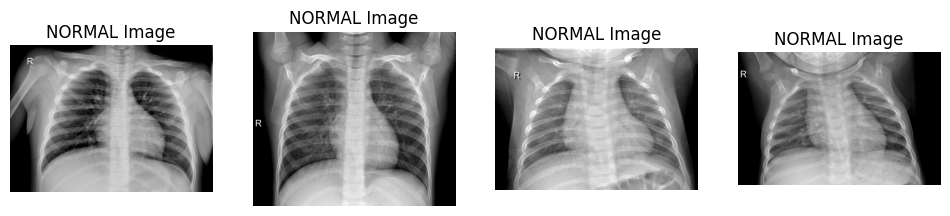

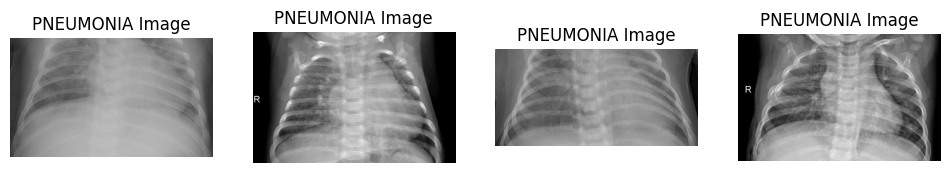

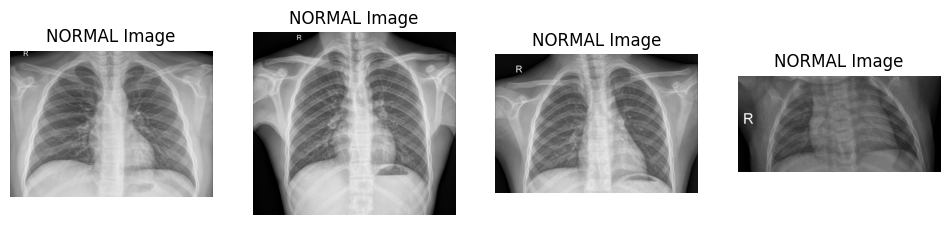

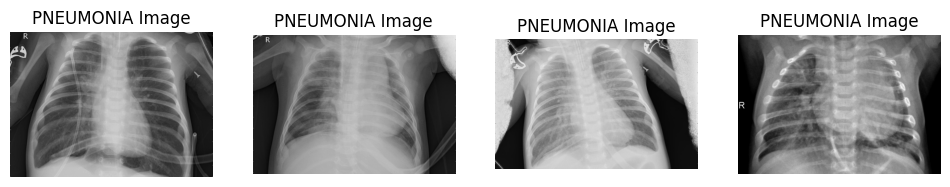

In [ ]:
display_sample_images(train_normal_dir, 'NORMAL')
display_sample_images(train_pneumonia_dir, 'PNEUMONIA')
display_sample_images(test_normal_dir, 'NORMAL')
display_sample_images(test_pneumonia_dir, 'PNEUMONIA')

In [ ]:
train_dir = '/content/drive/My Drive/Miniproject/chest_xray/train'
test_dir = '/content/drive/My Drive/Miniproject/chest_xray/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust the target size based on your model requirements
    batch_size=32,
    class_mode='binary',     # 'binary' for binary classification
)

Found 5216 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
)

Found 624 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
try:
    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=test_generator,
    )
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Make sure the dataset is correctly organized and all files are accessible.")

Epoch 1/5
163/163 [==============================] - 1124s 7s/step - loss: 0.3818 - accuracy: 0.8399 - val_loss: 0.7559 - val_accuracy: 0.7292
Epoch 2/5
163/163 [==============================] - 719s 4s/step - loss: 0.2146 - accuracy: 0.9135 - val_loss: 0.6841 - val_accuracy: 0.7420
Epoch 3/5
163/163 [==============================] - 732s 4s/step - loss: 0.1983 - accuracy: 0.9206 - val_loss: 0.5530 - val_accuracy: 0.8077
Epoch 4/5
163/163 [==============================] - 739s 5s/step - loss: 0.1792 - accuracy: 0.9321 - val_loss: 0.4706 - val_accuracy: 0.8510
Epoch 5/5
163/163 [==============================] - 767s 5s/step - loss: 0.1523 - accuracy: 0.9413 - val_loss: 0.3640 - val_accuracy: 0.8718


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

20/20 [==============================] - 28s 1s/step - loss: 0.3640 - accuracy: 0.8718
Test accuracy: 0.8717948794364929


In [ ]:
model.save('/content/drive/My Drive/Miniproject/chest_xray_model.h5')

In [ ]:
model.save('/content/drive/My Drive/Miniproject/xray_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/My Drive/Miniproject/chest_xray_model.h5')

In [ ]:
 model.save("xray_model.keras")

1/1 [==============================] - 0s 232ms/step


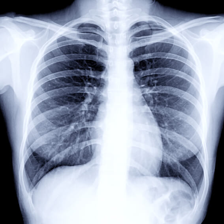

Predicted: NORMAL


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import IPython.display as display

def fetch_and_validate(model, image_url):
    # Fetch the image from the internet
    response = requests.get(image_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Read the image
        img = Image.open(BytesIO(response.content))
        img = img.resize((224, 224))  # Adjust size based on your model's input size
        img_array = np.array(img)
        img_array = img_array / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size

        # Make prediction
        prediction = model.predict(img_array)

        # Interpret the prediction
        if prediction[0, 0] > 0.5:
            predicted_label = "PNEUMONIA"
        else:
            predicted_label = "NORMAL"

        # Display the image and prediction
        display.display(img)
        print(f"Predicted: {predicted_label}")

        # Prompt for user validation
        user_input = getpass("Is the prediction correct? (y/n): ").lower()

        # Retrain the model if the prediction is incorrect
        if user_input == 'n':
            true_label = 1 if predicted_label == "NORMAL" else 0
            true_label = np.array([[true_label]])  # Adjust based on your label encoding
            model.fit(img_array, true_label, epochs=1)  # Assuming binary classification
            print("Model retrained with the correct label.")
        else:
            print("Model prediction is correct. No retraining needed.")

# Assuming 'loaded_model' is your loaded model
image_url = "https://mirxes.com/blog/wp-content/uploads/2022/12/normal-lung-xray.jpg"  # Replace with the actual image URL
fetch_and_validate(model, image_url)


In [ ]:
test_loss, test_acc = model.evaluate(test`_generator)
print(f'Test accuracy: {test_acc}')

163/163 [==============================] - 1563s 10s/step - loss: 0.1231 - accuracy: 0.9544
Test accuracy: 0.9543711543083191
